# LDA Analysis

## Main Research Questions
2021 年 3 月事件 (Atlanta Spa shootings) 發生前後的比較：
- 排名前十個概念 (concept) 是否有顯著不同
- 報導 Anti-Asian Racism 態度上是否不同（中立性、支持 Asian 性、強調 Anti-Asian 對社會上種族不平等的嚴重性）

## Read the data

In [82]:
# Read from date.txt and store the contents into a dictionary
import os
import json
import pandas as pd

df_news = pd.read_csv('news.csv')
df_news.head()


,id,source,date,contents
0,0,Boston Globe,202004,7/1/2021\nhttps://www-proquest-com.falcon.lib....
1,1,Boston Globe,202004,7/2/2021\nhttps://www-proquest-com.falcon.lib....
2,2,Boston Globe,202009,Find a copy\nAbstract\ndocument 1 of 1\nFull T...
3,3,Boston Globe,202102,Find a copy\nAbstract\ndocument 1 of 1\nFull T...
4,4,Boston Globe,202103,Find a copy\nAbstract\ndocument 1 of 1\nFull T...


## Data Preprocessing

In [83]:
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [84]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('S'):
        return wordnet.ADJ_SAT
    else:
        return wordnet.NOUN

def preprocess(articles):
    tokenizer = RegexpTokenizer(r'\b[^\'\d\W]+\b')
    nltk_stopwords = stopwords.words('english')
    our_stopwords = ['publication', 'document', 'newspaper', 'database', 'login', 'docview', 'copyright', 'se', 'llc', 'inc', 'id', 'title', 'citation', 'doi', 'mr', 'boston', 'globe', 'los', 'angeles', 'post', 'times', 'washington', 'asamnews', 'today']
    months_abbrev = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
    # Lowercase
    articles = [article.lower() for article in articles]
    # Remove Chinese characters
    articles = [re.sub(r'[\u4e00-\u9fff]+', '', article) for article in articles]
    # Execute tokenization
    tokenized_articles = [tokenizer.tokenize(article) for article in articles]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    preprocessed_articles = [pos_tag(article) for article in tokenized_articles]
    # Keep only nouns, verbs
    preprocessed_articles = [[(word, pos) for word, pos in article if pos in ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']] for article in preprocessed_articles]
    # Lemmatization
    preprocessed_articles = [[lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in article] for article in preprocessed_articles]
    # Remove words with length less than 3
    preprocessed_articles = [[word for word in article if len(word) > 2] for article in preprocessed_articles]
    # Stopwords removal
    preprocessed_articles = [[word for word in article if word.lower() not in nltk_stopwords] for article in preprocessed_articles]
    preprocessed_articles = [[word for word in article if word.lower() not in our_stopwords] for article in preprocessed_articles]
    preprocessed_articles = [[word for word in article if word.lower() not in months_abbrev] for article in preprocessed_articles]
    preprocessed_articles = [[word for word in article if word.lower() not in months] for article in preprocessed_articles]
    return preprocessed_articles


In [85]:
# Drop rows with missing values
df_news = df_news.dropna()
df_news['date'] = pd.to_datetime(df_news['date'], format='%Y%m')

df_news_before_202103 = df_news[df_news['date'] < '2021-03-01']
df_news_after_202103 = df_news[df_news['date'] >= '2021-03-01']

In [86]:
goal = 'after' # Choose 'before' or 'after'
articles_to_preprocess = df_news_after_202103['contents'].tolist()
preprocessed_articles = preprocess(articles_to_preprocess)

In [87]:
df_news_after_202103.groupby('date').size()


date
2021-03-01    243
2021-04-01    109
2021-05-01     28
2021-06-01     15
2021-07-01      4
2021-08-01      8
2021-09-01      5
2021-10-01      4
2021-11-01      1
2021-12-01      2
dtype: int64

/var/folders/ss/9b82800n1bq54s_0p7_m551c0000gn/T/ipykernel_44385/2229160297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_before_202103['date'] = df_news_before_202103['date'].dt.to_period('M')


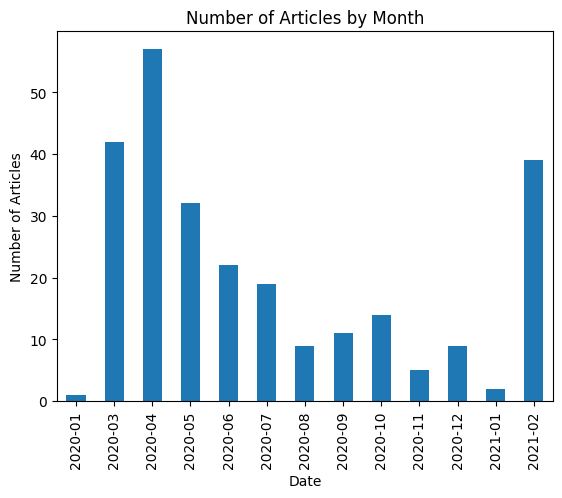

In [102]:
# 做每個月篇數的長條圖

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_news_before_202103['date'] = df_news_before_202103['date'].dt.to_period('M')
df_news_before_202103.groupby('date').size().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Number of Articles by Month')
plt.show()



## Create TF-IDF corpus

In [88]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [89]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(preprocessed_articles)
dictionary.filter_extremes(no_below=7, no_above=0.3)
corpus = [dictionary.doc2bow(article) for article in preprocessed_articles]

# Get TF-IDF scores
tfidf = TfidfModel(corpus)  
tfidf_corpus = tfidf[corpus]

## Train LDA model


用不同參數訓練 LDA ，並選擇一致性最高的模型

In [90]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Train LDA model
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto')
        model_list.append(model)
        # Compute coherence value
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [91]:
# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=preprocessed_articles, start=10, limit=15, step=1)
best_model = model_list[coherence_values.index(max(coherence_values))]

輸出各主題的前 20 名關鍵字

In [92]:
# Set the number of keywords to 20
num_keywords = 20
# Get the top keywords for each topic
topics = best_model.show_topics(num_topics=-1, num_words=num_keywords, formatted=False)
# Create a dictionary to store the keywords
keywords = {}
for topic in topics:
    keywords[topic[0]] = [word for word, _ in topic[1]]

# Save the keywords
with open(f'keywords_{goal}.json', 'w') as f:
    json.dump(keywords, f)
    

## Select the dominant topic for each document

對每篇文章選出最主要的主題。

選擇方法：每篇文章都有不同主題的機率分配，我們於此選出機率最高的主題。

In [93]:
# Get the most probable topic for each document
topics = best_model[corpus]
topics = [max(topic, key=lambda x: x[1]) for topic in topics]
print(topics[0])

(9, 0.27630743)


## Select the dominant documents for each topic

對於每個主題，選擇最具代表性的兩篇文章，並儲存

In [94]:
# Select 10 best documents for each topic
# Convert topics to a dataframe
topics_df = pd.DataFrame(topics, columns=['dominant topic', 'prob'])
topics_df['doc_id'] = topics_df.index
# Select 10 best documents for each topic
best_docs = topics_df.groupby('dominant topic').apply(lambda x: x.nlargest(2, 'prob')).reset_index(drop=True)
# Add articles to topics_df
best_docs['contents'] = [articles_to_preprocess[doc_id] for doc_id in best_docs['doc_id']]
# Save the best documents
best_docs.to_csv(f'best_docs_{goal}.csv', index=False)

In [95]:
# Count the number of documents for each topic
topic_counts = topics_df['dominant topic'].value_counts(normalize=True).sort_index()
# Sort the topics by the number of documents
topic_counts = topic_counts.sort_values(ascending=False)
print(topic_counts)

dominant topic
4    0.291169
2    0.176611
6    0.126492
3    0.109785
5    0.071599
0    0.062053
8    0.059666
7    0.040573
1    0.031026
9    0.031026
Name: proportion, dtype: float64


## Visualize the results

In [96]:
import pyLDAvis.gensim_models
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
pyLDAvis.save_html(vis, f'lda_{goal}_202103.html')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Playground

In [97]:
# Check the pos tag for "april, tuesday, wednesday, thursday, friday, saturday, sunday"

print(pos_tag(['america']))
print(pos_tag(['tuesday']))
print(pos_tag(['wednesday']))


[('america', 'NN')]
[('tuesday', 'NN')]
[('wednesday', 'NN')]


## Use OpenAI API to interpret the results
